In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV, KFold, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import warnings
warnings.filterwarnings('ignore')

np.random.seed(42)

In [ ]:
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')

print("Training data shape:", train_data.shape)
print("Testing data shape:", test_data.shape)
train_data.head()

Training data shape: (80000, 9)
Testing data shape: (20000, 8)


,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,target,ID
0,0.424460,-1.577970,-0.748530,1.159662,1.650649,-1.367809,1.284110,-202.335653,1
1,1.420967,1.285829,1.745047,2.219817,0.085850,0.747905,1.595173,600.020549,2
2,0.171008,-0.348894,-1.047437,0.092727,0.140626,-2.148354,0.027657,-302.092802,3
3,-1.380857,-1.506396,-0.476704,0.189526,-2.146807,0.623056,-0.135136,-205.487783,4
4,-0.488530,-0.509512,-0.681700,1.580970,-1.723643,0.870067,-0.548265,25.857605,5



Target variable statistics:
count    80000.000000
mean        -0.583496
std        181.309277
min       -776.141183
25%       -123.718320
50%         -0.663822
75%        122.787031
max        755.205266
Name: target, dtype: float64


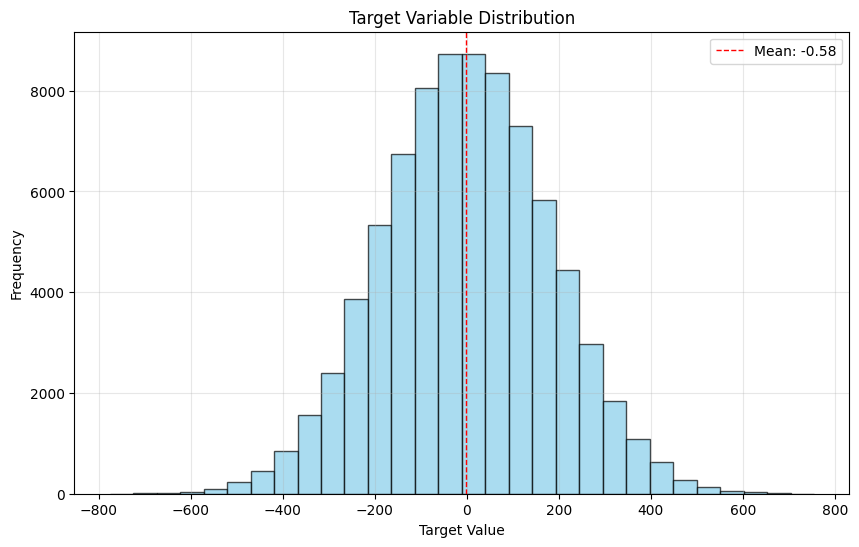

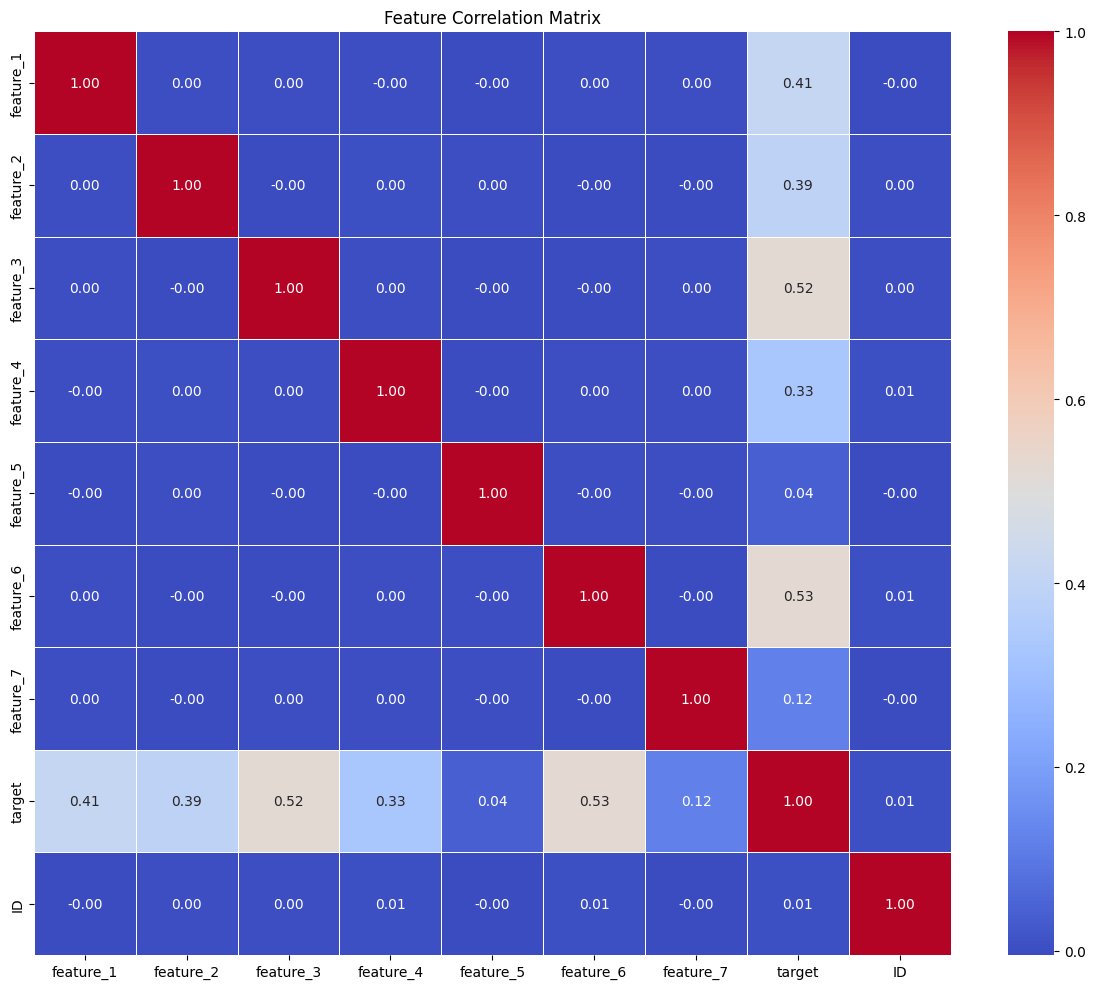

In [ ]:
print("\nTarget variable statistics:")
print(train_data['target'].describe())

plt.figure(figsize=(10, 6))
plt.hist(train_data['target'], bins=30, alpha=0.7, color='skyblue', edgecolor='black')
plt.axvline(train_data['target'].mean(), color='red', linestyle='dashed', linewidth=1, label=f"Mean: {train_data['target'].mean():.2f}")
plt.title('Target Variable Distribution')
plt.xlabel('Target Value')
plt.ylabel('Frequency')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

plt.figure(figsize=(12, 10))
correlation_matrix = train_data.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Feature Correlation Matrix')
plt.tight_layout()
plt.show()

In [ ]:
X = train_data.drop(['target'], axis=1)
if 'ID' in X.columns:
    X = X.drop(['ID'], axis=1)
    
y = train_data['target']

feature_names = X.columns.tolist()

X_test_final = test_data.copy()
if 'ID' in X_test_final.columns:
    test_ids = X_test_final['ID']
    X_test_final = X_test_final.drop(['ID'], axis=1)
else:
    test_ids = pd.Series(range(len(X_test_final)))

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training set: {X_train.shape}")
print(f"Validation set: {X_val.shape}")
print(f"Final test set: {X_test_final.shape}")

Training set: (64000, 7)
Validation set: (16000, 7)
Final test set: (20000, 7)


In [ ]:
def calculate_rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def evaluate_model(model, X_train, y_train, X_val, y_val, model_name):
    model.fit(X_train, y_train)
    
    y_train_pred = model.predict(X_train)
    y_val_pred = model.predict(X_val)
    
    train_rmse = calculate_rmse(y_train, y_train_pred)
    val_rmse = calculate_rmse(y_val, y_val_pred)
    train_r2 = r2_score(y_train, y_train_pred)
    val_r2 = r2_score(y_val, y_val_pred)
    
    print(f"{model_name} Performance:")
    print(f"Training RMSE: {train_rmse:.4f}")
    print(f"Validation RMSE: {val_rmse:.4f}")
    print(f"Training R²: {train_r2:.4f}")
    print(f"Validation R²: {val_r2:.4f}")
    
    return model, val_rmse

In [ ]:
import xgboost as xgb
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_final_scaled = scaler.transform(X_test_final)

models = {
    'XGBoost': xgb.XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42),
    'LightGBM': LGBMRegressor(n_estimators=100, learning_rate=0.1, random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
}

results = {}
for name, model in models.items():
    print(f"\nEvaluating {name}...")
    trained_model, val_rmse = evaluate_model(model, X_train_scaled, y_train, X_val_scaled, y_val, name)
    results[name] = {'model': trained_model, 'val_rmse': val_rmse}
    
best_model_name = min(results, key=lambda x: results[x]['val_rmse'])
print(f"\nBest base model: {best_model_name} with validation RMSE = {results[best_model_name]['val_rmse']:.4f}")


Evaluating XGBoost...
XGBoost Performance:
Training RMSE: 15.5276
Validation RMSE: 18.3462
Training R²: 0.9927
Validation R²: 0.9897

Evaluating LightGBM...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000865 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1785
[LightGBM] [Info] Number of data points in the train set: 64000, number of used features: 7
[LightGBM] [Info] Start training from score -0.526782
XGBoost Performance:
Training RMSE: 15.5276
Validation RMSE: 18.3462
Training R²: 0.9927
Validation R²: 0.9897

Evaluating LightGBM...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000865 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1785
[LightGBM] [Info] Number of data points in the train set: 64000, number of used features: 7
[LightGBM] [Info] Start training from score -0.526782
LightGBM Performance:
T

In [ ]:
param_grids = {
    'XGBoost': {
        'n_estimators': np.arange(100, 1000, 100),
        'max_depth': np.arange(3, 11),
        'learning_rate': [0.001, 0.01, 0.05, 0.1, 0.2],
        'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
        'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],
        'gamma': [0, 0.1, 0.2, 0.3],
        'min_child_weight': [1, 3, 5, 7],
        'reg_alpha': [0, 0.001, 0.01, 0.1, 1.0],
        'reg_lambda': [0, 0.001, 0.01, 0.1, 1.0]
    },
    'LightGBM': {
        'n_estimators': np.arange(100, 1000, 100),
        'num_leaves': [31, 63, 127, 255],
        'max_depth': [5, 10, 15, 20, 25],
        'learning_rate': [0.001, 0.01, 0.05, 0.1, 0.2],
        'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
        'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],
        'reg_alpha': [0, 0.001, 0.01, 0.1, 1.0],
        'reg_lambda': [0, 0.001, 0.01, 0.1, 1.0]
    },
    'Gradient Boosting': {
        'n_estimators': np.arange(100, 1000, 100),
        'max_depth': np.arange(3, 11),
        'learning_rate': [0.001, 0.01, 0.05, 0.1, 0.2],
        'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 5],
        'max_features': ['sqrt', 'log2', None]
    }
}

param_grid = param_grids[best_model_name]

if best_model_name == 'XGBoost':
    model_to_tune = xgb.XGBRegressor(random_state=42)
elif best_model_name == 'LightGBM':
    model_to_tune = LGBMRegressor(random_state=42)
else:
    model_to_tune = GradientBoostingRegressor(random_state=42)

print(f"Starting hyperparameter tuning for {best_model_name}...")
random_search = RandomizedSearchCV(
    estimator=model_to_tune,
    param_distributions=param_grid,
    n_iter=50,
    cv=5,
    scoring='neg_root_mean_squared_error',
    verbose=1,
    random_state=42,
    n_jobs=-1
)

random_search.fit(X_train_scaled, y_train)

print("\nBest parameters:")
print(random_search.best_params_)

best_tuned_model = random_search.best_estimator_

y_val_pred = best_tuned_model.predict(X_val_scaled)
best_val_rmse = calculate_rmse(y_val, y_val_pred)
best_val_r2 = r2_score(y_val, y_val_pred)

print(f"\nBest Tuned {best_model_name} Performance:")
print(f"Validation RMSE: {best_val_rmse:.4f}")
print(f"Validation R²: {best_val_r2:.4f}")

Starting hyperparameter tuning for XGBoost...
Fitting 5 folds for each of 50 candidates, totalling 250 fits

Best parameters:
{'subsample': 0.9, 'reg_lambda': 0.1, 'reg_alpha': 1.0, 'n_estimators': np.int64(600), 'min_child_weight': 1, 'max_depth': np.int64(3), 'learning_rate': 0.05, 'gamma': 0.1, 'colsample_bytree': 0.8}

Best Tuned XGBoost Performance:
Validation RMSE: 13.3069
Validation R²: 0.9946

Best parameters:
{'subsample': 0.9, 'reg_lambda': 0.1, 'reg_alpha': 1.0, 'n_estimators': np.int64(600), 'min_child_weight': 1, 'max_depth': np.int64(3), 'learning_rate': 0.05, 'gamma': 0.1, 'colsample_bytree': 0.8}

Best Tuned XGBoost Performance:
Validation RMSE: 13.3069
Validation R²: 0.9946


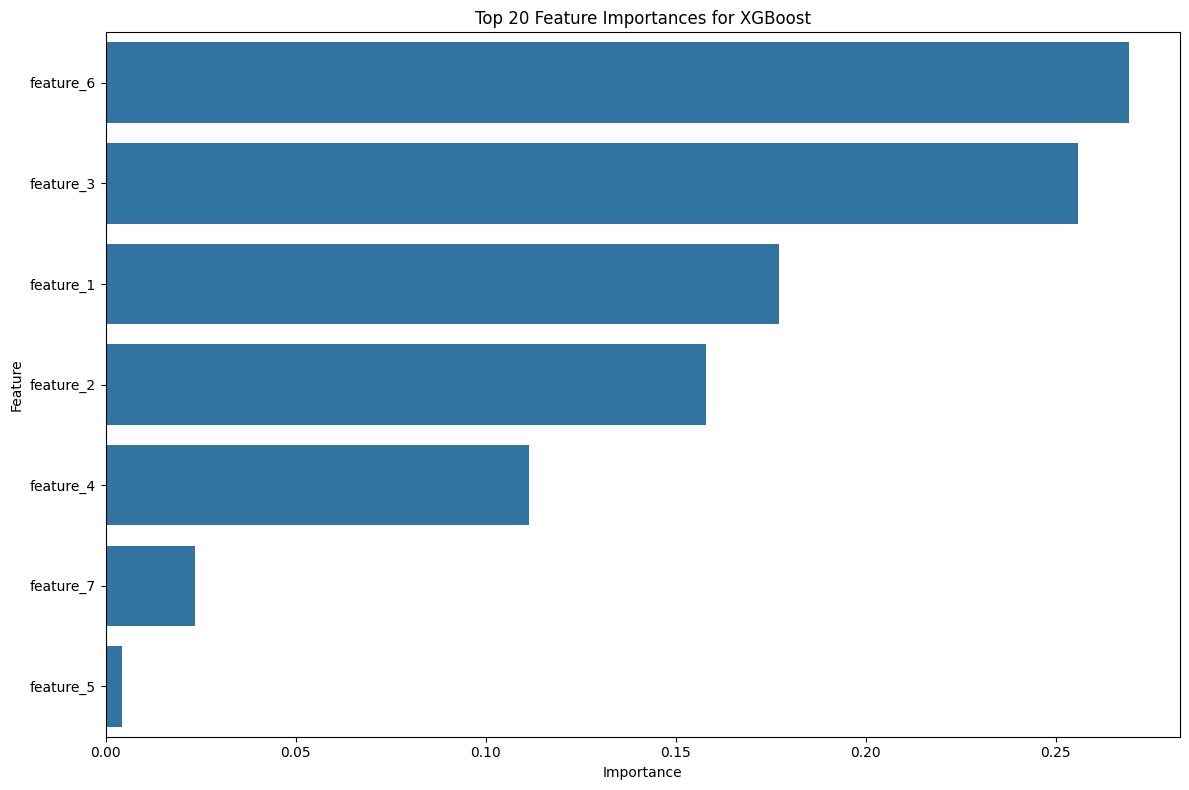

     Feature  Importance
0  feature_6    0.269262
1  feature_3    0.255838
2  feature_1    0.177314
3  feature_2    0.158043
4  feature_4    0.111531
5  feature_7    0.023602
6  feature_5    0.004410


In [ ]:
if hasattr(best_tuned_model, 'feature_importances_'):
    importances = best_tuned_model.feature_importances_
    
    feature_importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importances
    })
    
    feature_importance_df = feature_importance_df.sort_values('Importance', ascending=False).reset_index(drop=True)
    
    plt.figure(figsize=(12, 8))
    sns.barplot(x='Importance', y='Feature', data=feature_importance_df[:20])
    plt.title(f'Top 20 Feature Importances for {best_model_name}')
    plt.tight_layout()
    plt.show()
    
    print(feature_importance_df[:10])
else:
    print("Feature importances not available for this model type.")

In [ ]:
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import Ridge

base_models = [
    ('xgb', xgb.XGBRegressor(**random_search.best_params_ if best_model_name == 'XGBoost' else {'random_state': 42})),
    ('lgbm', LGBMRegressor(**random_search.best_params_ if best_model_name == 'LightGBM' else {'random_state': 42})),
    ('gbr', GradientBoostingRegressor(**random_search.best_params_ if best_model_name == 'Gradient Boosting' else {'random_state': 42}))
]

stack_model = StackingRegressor(
    estimators=base_models,
    final_estimator=Ridge(alpha=0.1),
    cv=5,
    n_jobs=-1
)

print("Training stacked ensemble model...")
stack_model.fit(X_train_scaled, y_train)

y_val_stack_pred = stack_model.predict(X_val_scaled)
stack_val_rmse = calculate_rmse(y_val, y_val_stack_pred)
stack_val_r2 = r2_score(y_val, y_val_stack_pred)

print(f"\nStacked Ensemble Performance:")
print(f"Validation RMSE: {stack_val_rmse:.4f}")
print(f"Validation R²: {stack_val_r2:.4f}")

Training stacked ensemble model...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.022156 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1785
[LightGBM] [Info] Number of data points in the train set: 64000, number of used features: 7
[LightGBM] [Info] Start training from score -0.526782
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.022156 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1785
[LightGBM] [Info] Number of data points in the train set: 64000, number of used features: 7
[LightGBM] [Info] Start training from score -0.526782
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003055 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1785
[LightGBM] [Info] Number of data points in the train set: 51200, number of used featu

/home/shush/Desktop/ffs/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/shush/Desktop/ffs/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/shush/Desktop/ffs/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/shush/Desktop/ffs/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/shush/Desktop/ffs/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fit


Stacked Ensemble Performance:
Validation RMSE: 13.1401
Validation R²: 0.9947


Selected final model: Stacked Ensemble
Final validation RMSE: 13.1401
Final validation R²: 0.9947


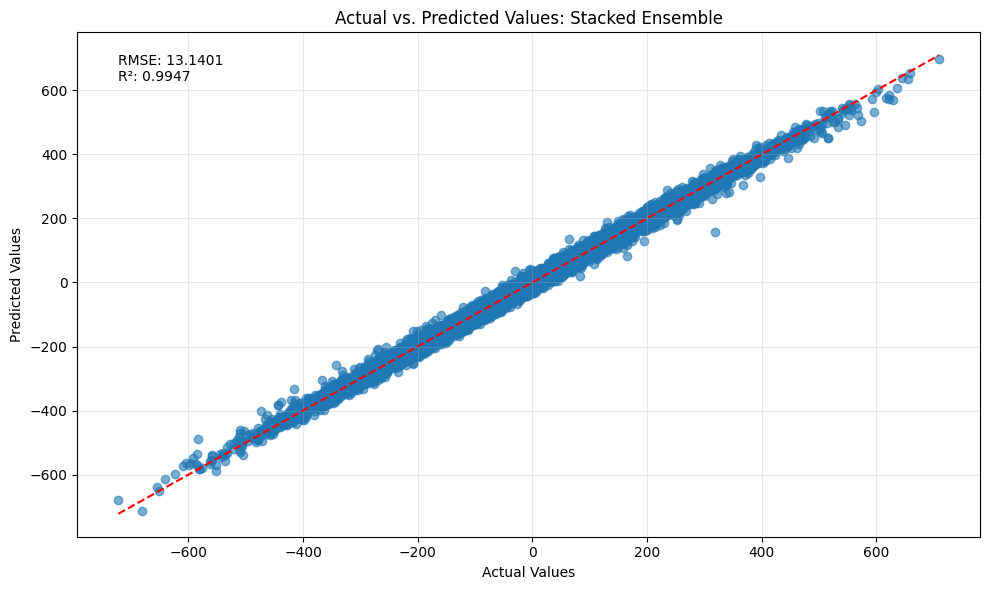

In [ ]:
if stack_val_rmse < best_val_rmse:
    final_model = stack_model
    final_model_name = "Stacked Ensemble"
    final_val_rmse = stack_val_rmse
    final_val_r2 = stack_val_r2
else:
    final_model = best_tuned_model
    final_model_name = f"Optimized {best_model_name}"
    final_val_rmse = best_val_rmse
    final_val_r2 = best_val_r2
    
print(f"Selected final model: {final_model_name}")
print(f"Final validation RMSE: {final_val_rmse:.4f}")
print(f"Final validation R²: {final_val_r2:.4f}")

if final_model_name == "Stacked Ensemble":
    final_pred = stack_model.predict(X_val_scaled)
else:
    final_pred = best_tuned_model.predict(X_val_scaled)
    
plt.figure(figsize=(10, 6))
plt.scatter(y_val, final_pred, alpha=0.6)
plt.plot([min(y_val), max(y_val)], [min(y_val), max(y_val)], 'r--')
plt.title(f'Actual vs. Predicted Values: {final_model_name}')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.text(min(y_val), max(final_pred)*0.9, f'RMSE: {final_val_rmse:.4f}\nR²: {final_val_r2:.4f}')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

In [ ]:
print(f"Retraining {final_model_name} on full training dataset...")
X_full_scaled = scaler.transform(X)
final_model.fit(X_full_scaled, y)

test_predictions = final_model.predict(X_test_final_scaled)

submission = pd.DataFrame({
    'ID': test_ids,
    'target': test_predictions
})

submission_file = 'optimized_submission.csv'
submission.to_csv(submission_file, index=False)
print(f"\nPredictions saved to {submission_file}")
submission.head()

Retraining Stacked Ensemble on full training dataset...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.029073 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1785
[LightGBM] [Info] Number of data points in the train set: 80000, number of used features: 7
[LightGBM] [Info] Start training from score -0.583496
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004545 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1785
[LightGBM] [Info] Number of data points in the train set: 64000, number of used features: 7
[LightGBM] [Info] Start training from score -0.100389
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010564 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1785


/home/shush/Desktop/ffs/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/shush/Desktop/ffs/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/shush/Desktop/ffs/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/shush/Desktop/ffs/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/shush/Desktop/ffs/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fit


Predictions saved to optimized_submission.csv


,ID,target
0,80001,85.326959
1,80002,345.731993
2,80003,-226.905405
3,80004,110.667849
4,80005,6.120509
